![logo](../../LogoLine_horizon_C3S.png)

<div class="alert alert-block alert-warning">
Please note that this repository is used for development and review, so quality assessments should be considered work in progress until they are merged into the main branch
</div>

# ERA5-Land temperature trend for climate change analysis in Spain

Production date: 04-10-2025

Produced by: Amaya Camila Trigoso Barrientos (VUB) & Cristina Deidda (VUB)

## 🌍 Use case: Monitor climate change over Spain with land reanalysis data

## ❓ Quality assessment question
* **Are the monthly averaged temperature data from ERA5-Land suitable for recovering the trend of annual mean temperature increase in Spain in order to monitor climate change?**

ERA5-Land contains global reanalysis data with different levels of aggregation: hourly and monthly average. One of the most analyzed variable provided is the "2m temperature". Temperature data are important to assess climatology and trends for climate change analysis. In this assessment, we evaluate the feasibility of using ERA5-Land monthly averaged data to compute the annual mean temperature trend at the country level, focusing on Spain. To validate the analysis, results are compared with those from Arellano et al. (2025) [[1]](https://doi.org/10.3390/land14010085) and the CRU TS (Climatic Research Unit gridded Time Series) dataset [[2]](https://doi.org/10.1038/s41597-020-0453-3) accessed via the Climate Change Knowledge Portal [[3]](https://climateknowledgeportal.worldbank.org/country/spain/climate-data-historical).

## 📢 Quality assessment statement

```{admonition} These are the key outcomes of this assessment
:class: note
* Both ERA5-Land and CRU show a significant warming trend over Spain (1971-2022), consistent with previously published results based on E-OBS data [[1]](https://doi.org/10.3390/land14010085), indicating a regional temperature increase of approximately 0.04 °C per year. 
* ERA5-Land exhibits a systematic cold bias relative to CRU, averaging -0.49 °C, with larger deviations during colder months.
* Despite the bias, correlation between ERA5-Land and CRU is nearly perfect, and error metrics such as MAE and RMSE (~0.6-0.7 °C) remain low and stable across seasons, suggesting strong temporal agreement between datasets.
```

## 📋 Methodology

First, the 2 m air temperature variable from ERA5-Land was downloaded for the Spanish domain, converted from Kelvin to Celsius, and clipped using a national boundary shapefile. Annual mean temperatures were calculated for the period 1971–2022, and long-term trends were analyzed using the non-parametric Mann–Kendall test to assess statistical significance. The same procedure was applied to CRU annual temperature data to enable a consistent comparison. The trend obtained were also compared agains the results form Arellano et al. (2025) [[1]](https://doi.org/10.3390/land14010085). To evaluate the agreement between datasets at higher temporal resolution, monthly means were used to compute the Mean Bias Error (MBE), Mean Absolute Error (MAE), Root Mean Square Error (RMSE), and Pearson correlation coefficient, both annually and seasonally. Finally, a spatial bias analysis was performed for the 1991–2020 climatological period by resampling ERA5-Land to match the 0.5° grid of CRU and mapping the mean difference between the two datasets. This approach allowed both temporal and spatial evaluation of temperature consistency and bias between reanalysis and observationally based products.

**[](reanalysis_reanalysis-era5-land-monthly-means_climate-monitoring_q01:section-1)**
 * Download the 2 m air temperature variable (K) from ERA5-Land, selecting the spatial extent covering Spain.
 * Convert temperature values from Kelvin to Celsius.
 * Define a function to clip the ERA5-Land data using a shapefile of Spain.

**[](reanalysis_reanalysis-era5-land-monthly-means_climate-monitoring_q01:section-2)**
 * Compute spatial and annual mean temperatures from the ERA5-Land dataset.
 * Select the 1971–2022 period to compare with temperature trends reported in the literature.
 * Analyze temperature trends and their significance using the Mann–Kendall test.
 * Download the annual mean time series from the CRU dataset for the same period.
 * Perform the Mann–Kendall trend analysis on CRU data to assess consistency between the two datasets.
 * Plot and compare the annual mean temperature time series from ERA5-Land and CRU.

**[](reanalysis_reanalysis-era5-land-monthly-means_climate-monitoring_q01:section-3)**
 * Download the monthly mean temperature time series for Spain from CRU.
 * Calculate the monthly mean for ERA5-Land (1950-2024).
 * Compute MBE, MAE, RMSE, and the Pearson correlation coefficient between ERA5-Land and CRU monthly data.
 * Group results by season (DJF, MAM, JJA, SON) and compute the same error metrics to assess seasonal performance.

**[](reanalysis_reanalysis-era5-land-monthly-means_climate-monitoring_q01:section-4)**
 * Download the annual mean temperature raster for Spain (1991–2020) from CRU.
 * Extract the same 1991–2020 period from ERA5-Land and compute the mean temperature over time.
 * Resample ERA5-Land data to the 0.5° resolution of the CRU dataset.
 * Calculate the mean bias (ERA5-Land − CRU) for each grid cell.
 * Plot the spatial distribution of the mean bias across Spain.
 * Discuss spatial patterns and possible sources of bias.

## 📈 Analysis and results

(reanalysis_reanalysis-era5-land-monthly-means_climate-monitoring_q01:section-1)=
### 1. Set request and download

#### Import packages
Import c3s_eqc_automatic_quality_control library and packages to calculate the statistics.

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import fsspec
import os
import io
import requests
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import pymannkendall as mk
import shapely
import shapely.geometry
import xarray as xr
import tempfile
import zipfile
import rioxarray
from c3s_eqc_automatic_quality_control import diagnostics, download, plot
import rasterio
from rasterio.mask import mask

plt.style.use("seaborn-v0_8-notebook")

#### Set data request
Select the request, specifying the type of variable (monthly averaged reanalysis), variable (2m temperature) and the latitude and longitude coordinates for Spain including islands outside mainland territory.

In [2]:
collection_id = "reanalysis-era5-land-monthly-means"
request = {
    "product_type": ["monthly_averaged_reanalysis"],
    "variable": ["2m_temperature"],
    "year": [
        "1950", "1951", "1952",
        "1953", "1954", "1955",
        "1956", "1957", "1958",
        "1959", "1960", "1961",
        "1962", "1963", "1964",
        "1965", "1966", "1967",
        "1968", "1969", "1970",
        "1971", "1972", "1973",
        "1974", "1975", "1976",
        "1977", "1978", "1979",
        "1980", "1981", "1982",
        "1983", "1984", "1985",
        "1986", "1987", "1988",
        "1989", "1990", "1991",
        "1992", "1993", "1994",
        "1995", "1996", "1997",
        "1998", "1999", "2000",
        "2001", "2002", "2003",
        "2004", "2005", "2006",
        "2007", "2008", "2009",
        "2010", "2011", "2012",
        "2013", "2014", "2015",
        "2016", "2017", "2018",
        "2019", "2020", "2021",
        "2022", "2023", "2024"
    ],
    "month": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12"
    ],
    "time": ["00:00"],
    "data_format": "grib",
    "download_format": "zip",
    "area": [44, -18, 27, 6]
}

#### Download data and convert to Celsius
Download considering 1 year chuncks.

In [3]:
ds = download.download_and_transform(collection_id, request, chunks={"year": 1})
da = ds["t2m"]
with xr.set_options(keep_attrs=True):
    da -= 273.15
da.attrs["units"] = "°C"

100%|██████████| 75/75 [00:03<00:00, 23.17it/s]
/data/common/miniforge3/envs/wp5/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode the variable 'step' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/data/common/miniforge3/envs/wp5/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode the variable 'step' into a timedelta64 dtype based on the presence of a timedelta-like 'u

#### Function to select and cut Spain map
Function to read Spain shapefile and cut the map.

In [4]:
def clip_gadm_remote(data, url, layer_name):
    """
    Clip an xarray DataArray or Dataset using a GADM shapefile from a remote ZIP.

    Parameters:
        data: xarray.DataArray or Dataset
        url: str, URL to the zipped GADM shapefile
        layer_name: str, e.g. "gadm41_ESP_0", "gadm41_ESP_1", etc.

    Returns:
        Clipped xarray object
    """
    with tempfile.TemporaryDirectory() as tmpdir:
        # Download the zip
        zip_path = os.path.join(tmpdir, "gadm.zip")
        r = requests.get(url)
        r.raise_for_status()
        with open(zip_path, "wb") as f:
            f.write(r.content)

        # Unzip
        with zipfile.ZipFile(zip_path, "r") as zip_ref:
            zip_ref.extractall(tmpdir)

        # Build path to the chosen layer (each is a separate .shp file)
        shp_path = os.path.join(tmpdir, f"{layer_name}.shp")
        if not os.path.exists(shp_path):
            raise FileNotFoundError(f"Could not find {layer_name}.shp in the extracted archive")

        # Load shapefile
        gdf = gpd.read_file(shp_path)

        # Ensure CRS matches
        shapefile_crs = "EPSG:4326"
        gdf = gdf.to_crs(shapefile_crs)

        # Prepare xarray for clipping
        data = data.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=False)
        data = data.rio.write_crs(shapefile_crs, inplace=False)

        # Clip
        data_clip = data.rio.clip(
            gdf.geometry.apply(shapely.geometry.mapping), gdf.crs, drop=False
        )

    return data_clip

In [5]:
url = "https://geodata.ucdavis.edu/gadm/gadm4.1/shp/gadm41_ESP_shp.zip"
layer = "gadm41_ESP_0"  # national boundaries for Spain

In [6]:
da = clip_gadm_remote(da, url, layer)

(reanalysis_reanalysis-era5-land-monthly-means_climate-monitoring_q01:section-2)=
### 2. Trend and significance with Mann Kendall Test

Calculate trend and significance with Mann Kendall Test and check for significance using ERA5-Land data. The period 1971-2022 was selected to compare with the results from Arellano et al. (2025), who quantified the warming trend in Spain during this period using the ordinary least squares (OLS) regression method [[1]](https://doi.org/10.3390/land14010085). 

In [7]:
da_spatial_mean = diagnostics.spatial_weighted_mean(da)
da_annual_mean = diagnostics.annual_weighted_mean(da_spatial_mean)

In [8]:
da_sel_71 = da_annual_mean.sel(year=slice("1971", "2022"))

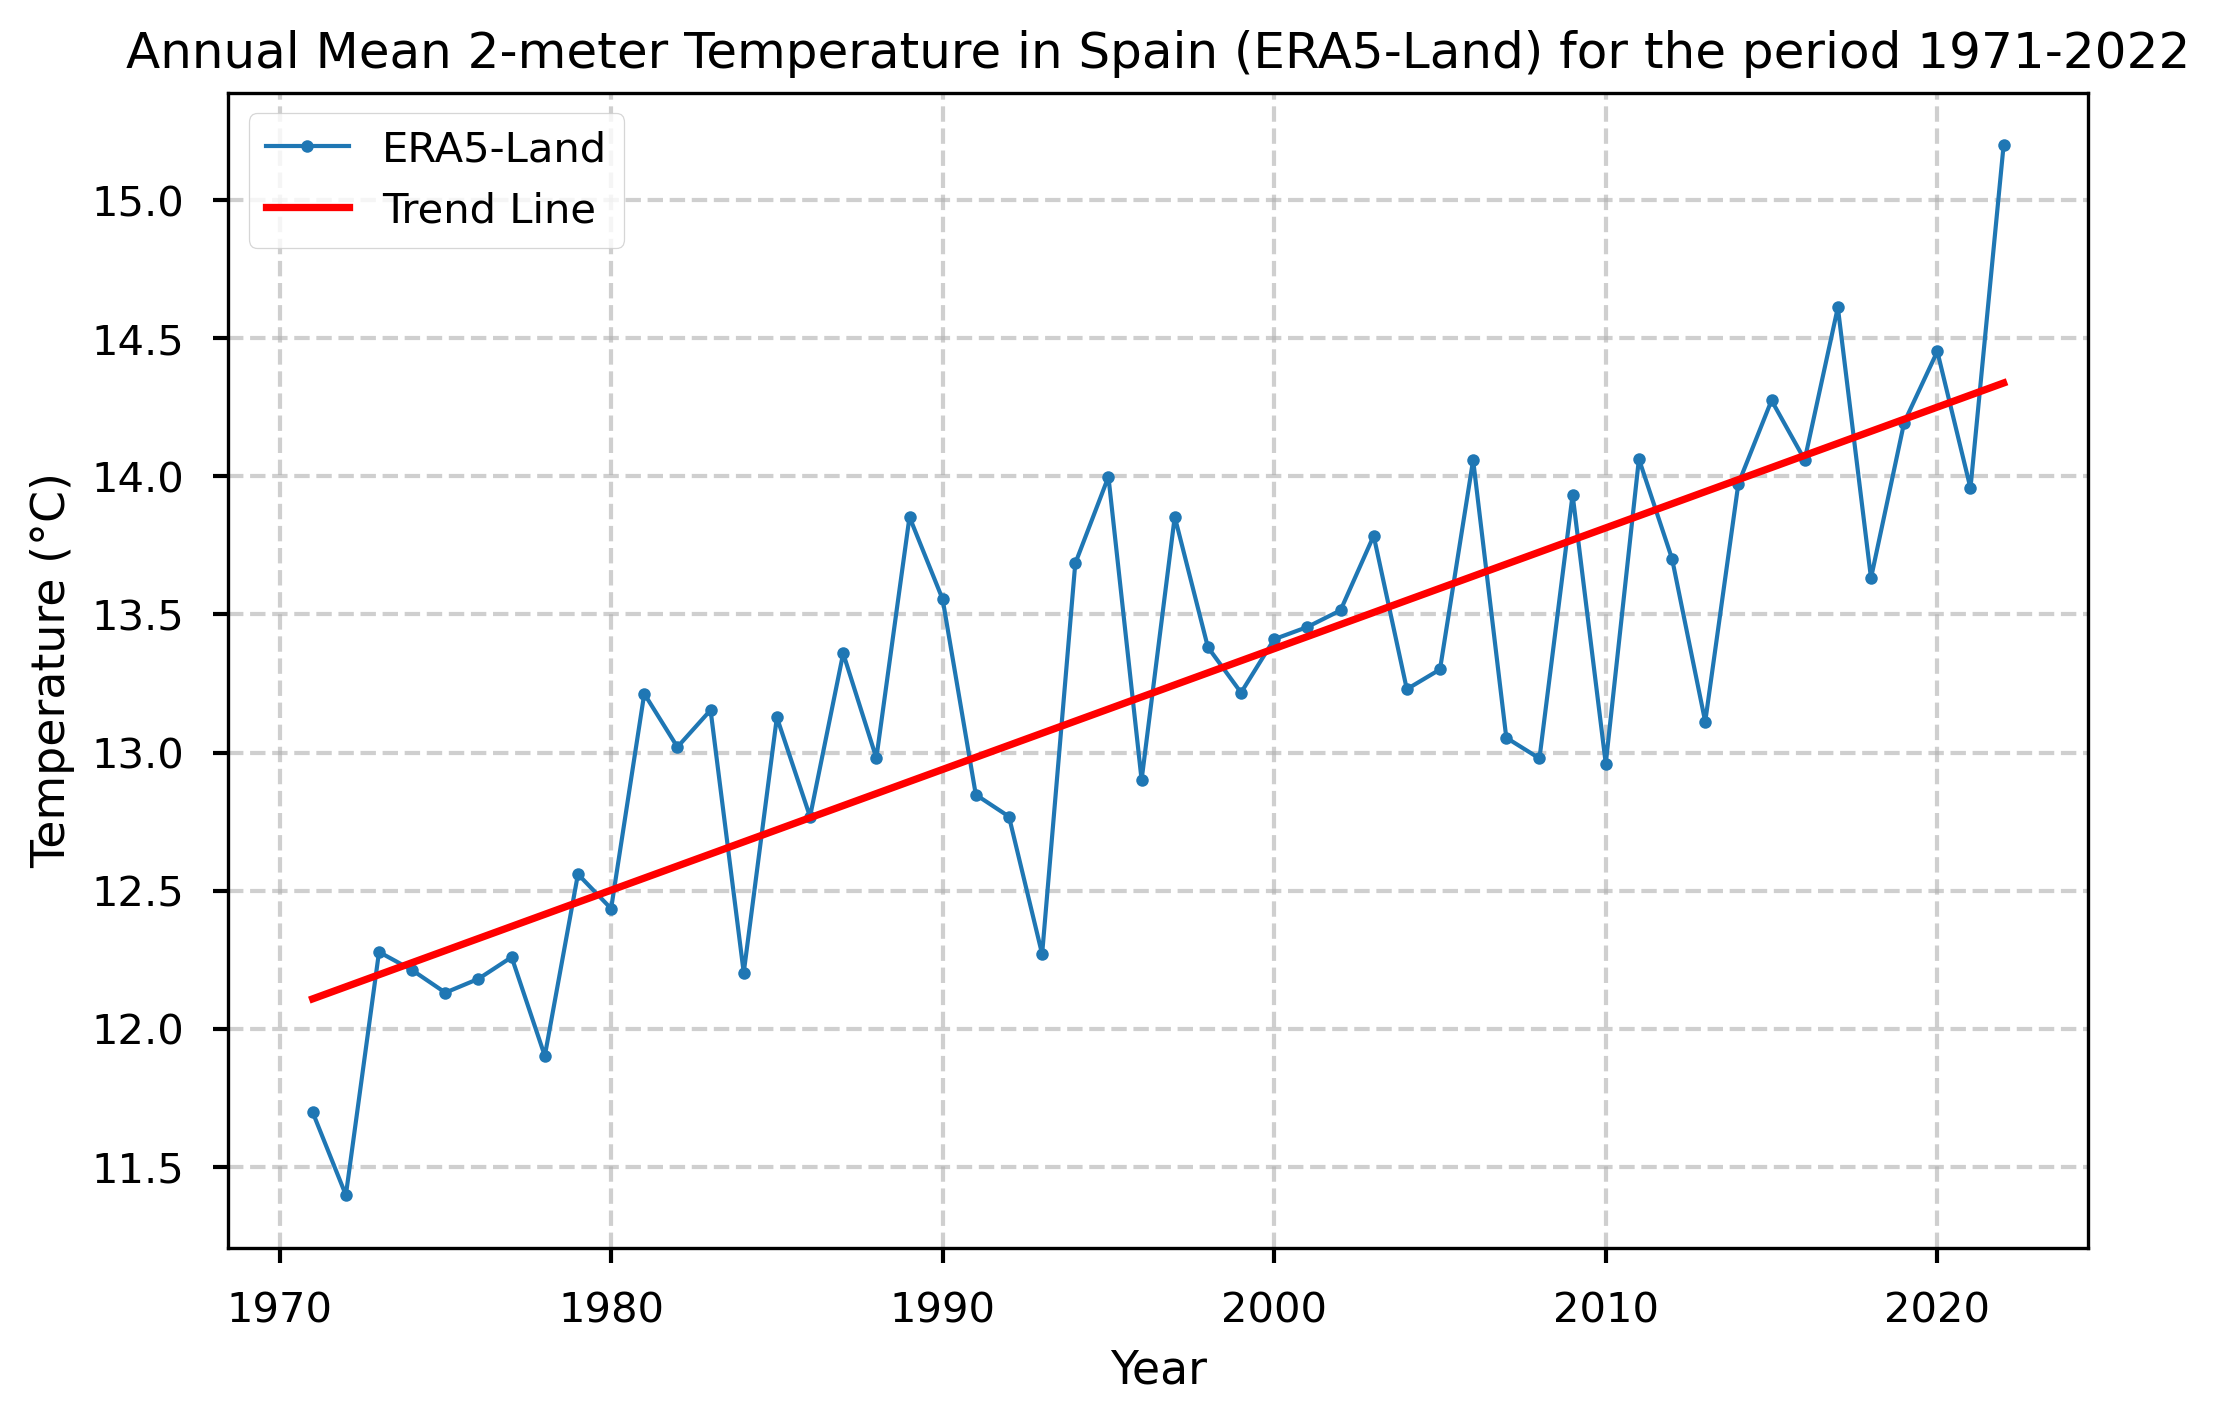

The trend is significant.
Trend: 0.0437 °C/year


In [9]:
# Run Mann-Kendall test
trend, h, p, z, tau, s, var_s, slope, intercept = mk.original_test(da_sel_71)

# Plot
plt.figure(figsize=(8,5), dpi=300)
plt.plot(da_sel_71["year"], da_sel_71, label="ERA5-Land", marker="o", markersize=3, linewidth=1)

# Trend line
plt.plot(da_sel_71["year"], slope * np.arange(da_sel_71.sizes["year"]) + intercept, label="Trend Line", color="red")

# Legend and labels
plt.legend()
plt.title("Annual Mean 2-meter Temperature in Spain (ERA5-Land) for the period 1971-2022")
plt.xlabel("Year")
plt.ylabel("Temperature (°C)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# Print results
is_significant = p < 0.05
print(f"The trend is{'' if is_significant else ' NOT'} significant.")
print(f"Trend: {slope:.4f} °C/year")

*Figure 1. ERA5-Land annual 2-meter temperature trend in Spain for the period 1971-2022 using Mann Kendall test.*

CRU TS (Climatic Research Unit gridded Time Series) is a global climate dataset (except Antartica) with 0.5° spatial resolution. It is produced by interpolating monthly climate anomalies from a large network of weather station observations [[2]](https://doi.org/10.1038/s41597-020-0453-3). The Climate Knowledge Portal [[3]](https://climateknowledgeportal.worldbank.org/country/spain/climate-data-historical) provides access to downloadable datasets from different models including the CRU dataset. This data is visualized on the portal's main page, where users can examine climate statistics for various countries. Here, we analyze the annual average surface air temperatures from the CRU model for Spain.

In [10]:
# Import CRU yearly data
yearly_url = "https://cckpapi.worldbank.org/cckp/v1/cru-x0.5_timeseries_tas_timeseries_annual_1901-2024_mean_historical_cru_ts4.09_mean/ESP?_format=json"
yearly_resp = requests.get(yearly_url)
yearly_data = yearly_resp.json()

# Extract the ESP dict
yearly_esp_data = yearly_data["data"]["ESP"]

# Convert to DataFrame
yearly_df = pd.DataFrame(list(yearly_esp_data.items()), columns=["date", "tas_mean"])

# Convert year strings ("1901-07") into datetime or just year
yearly_df["date"] = pd.to_datetime(yearly_df["date"], format="%Y-%m")
yearly_df.set_index("date", inplace=True)
df_yearly_cru = yearly_df.loc["1971-01-01":"2022-12-01"]

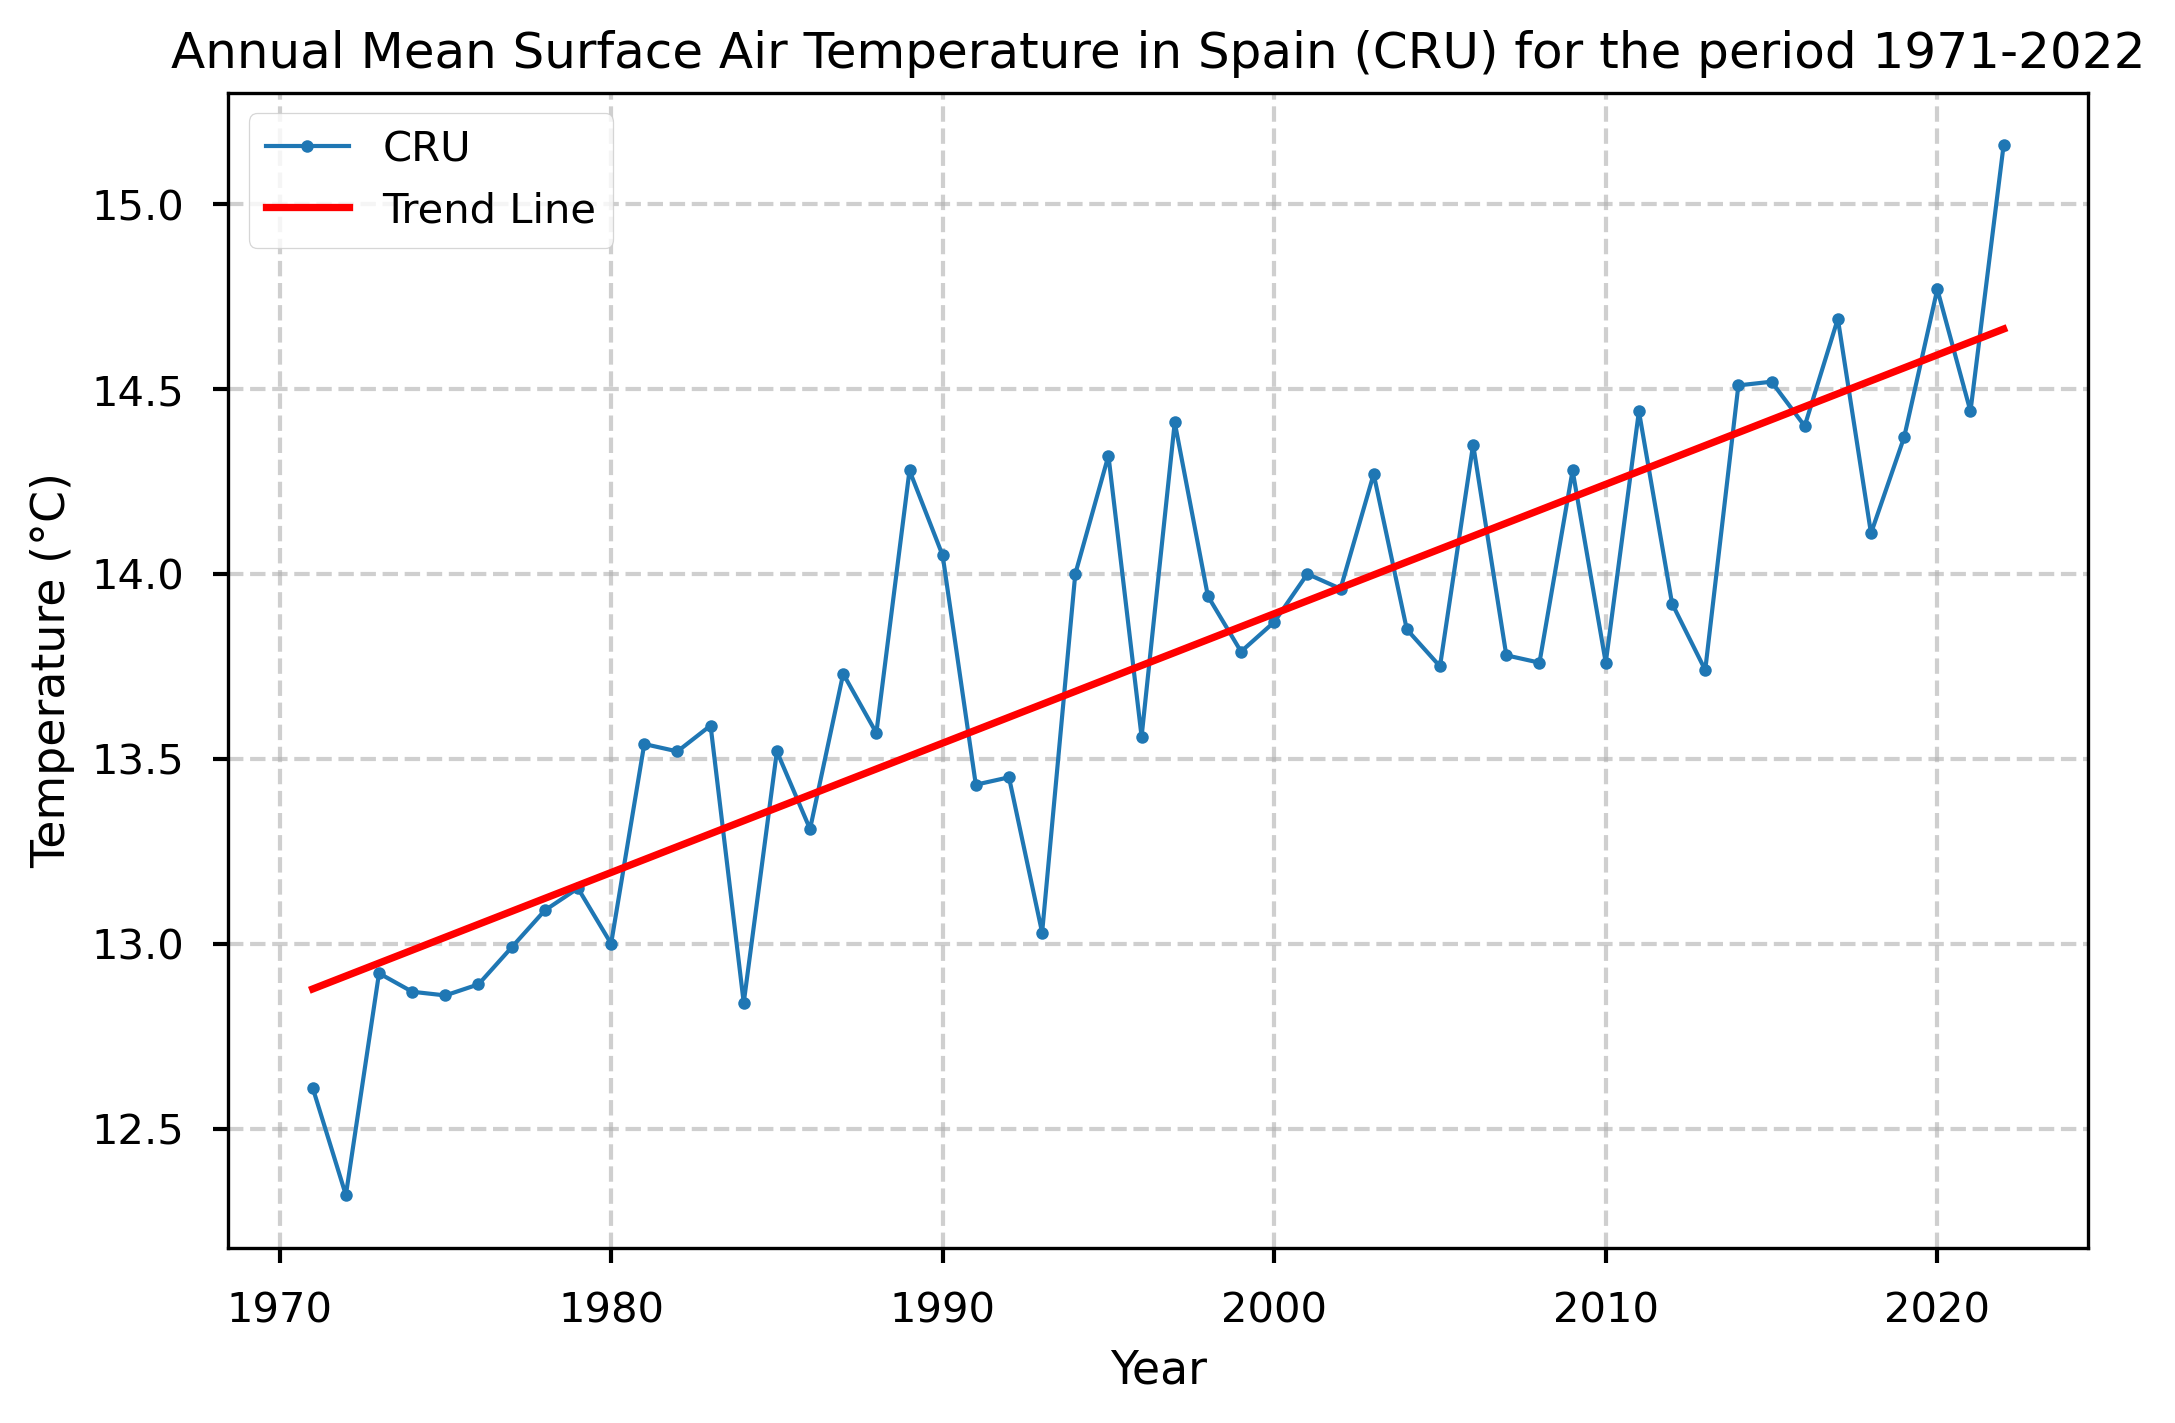

The trend is significant.
Trend: 0.0350 °C/year


In [13]:
# Extract years and values
years_cru = df_yearly_cru.index.year.values
temps_cru = df_yearly_cru["tas_mean"].values

# Run Mann-Kendall test
trend, h, p, z, tau, s, var_s, slope, intercept = mk.original_test(temps_cru)

# Plot
plt.figure(figsize=(8,5), dpi=300)
plt.plot(years_cru, temps_cru, label="CRU", marker="o", markersize=3, linewidth=1)

# Trend line
plt.plot(years_cru, slope * np.arange(len(years_cru)) + intercept, 
         label="Trend Line", color="red")

# Legend and labels
plt.legend()
plt.title("Annual Mean Surface Air Temperature in Spain (CRU) for the period 1971-2022")
plt.xlabel("Year")
plt.ylabel("Temperature (°C)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# Print results
is_significant = p < 0.05
print(f"The trend is{'' if is_significant else ' NOT'} significant.")
print(f"Trend: {slope:.4f} °C/year")

*Figure 2. CRU annual surface air temperature trend in Spain for the period 1971-2022 using Mann Kendall test.*

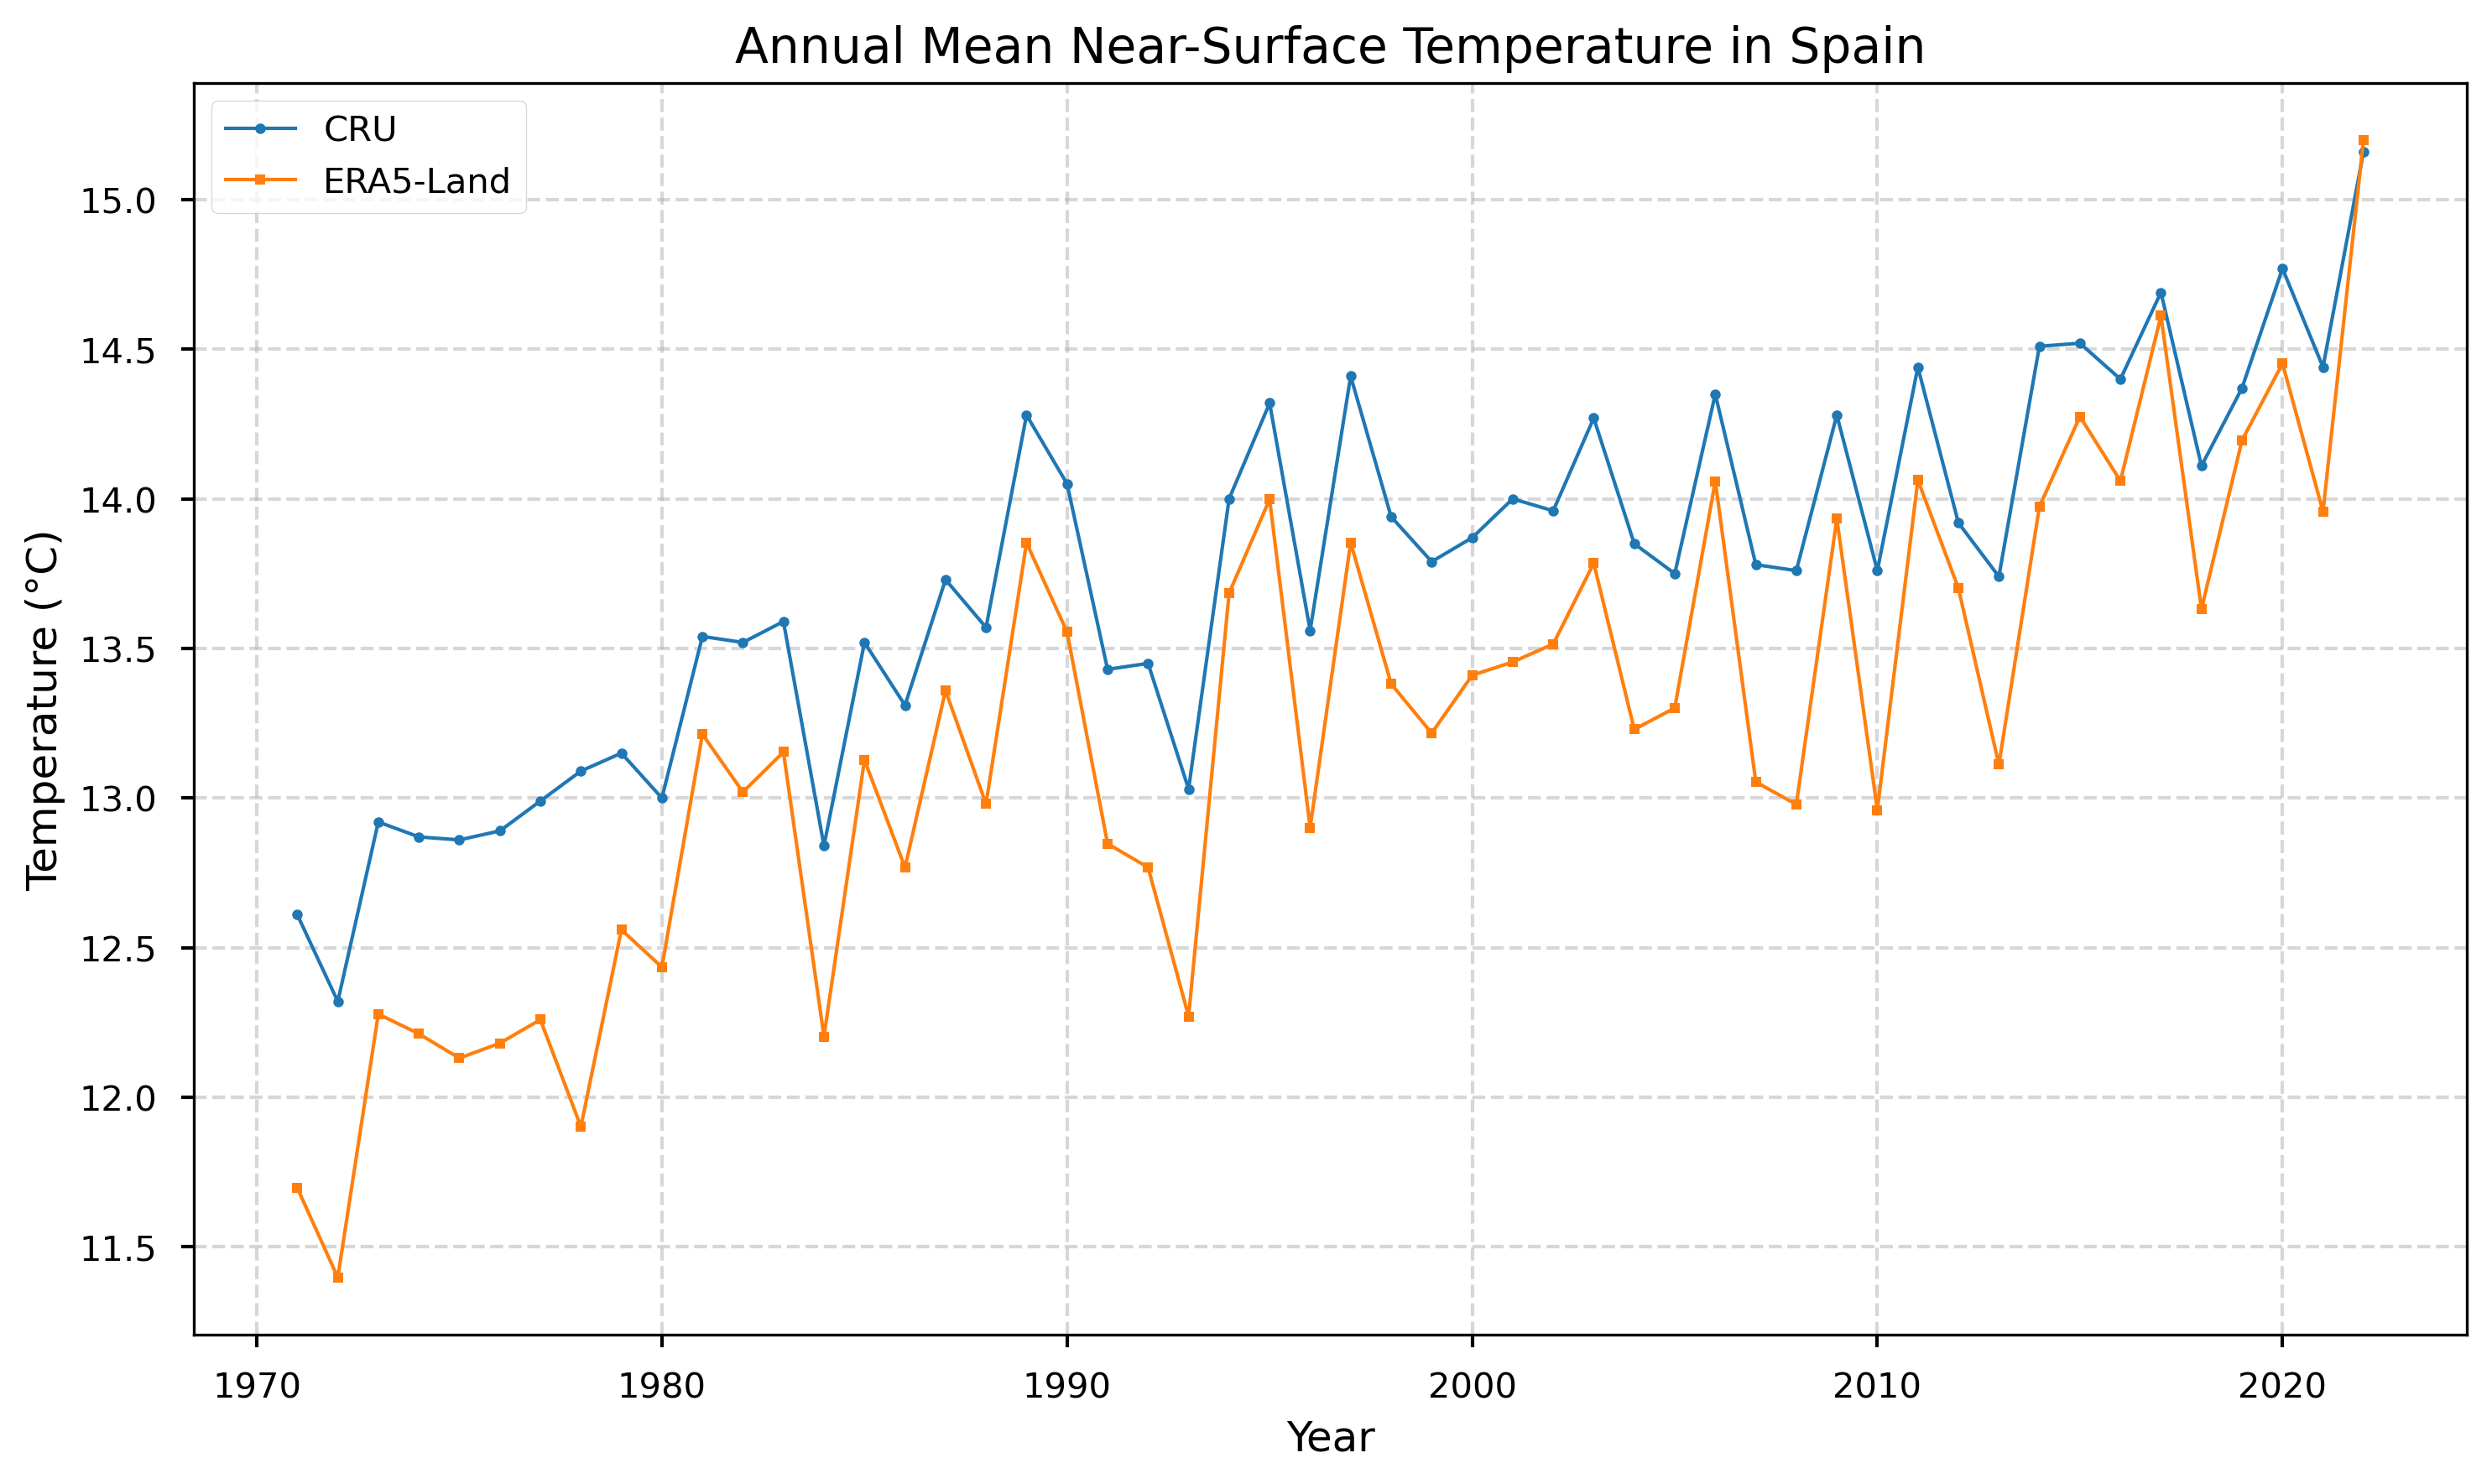

In [15]:
# Extract ERA5-Land data
years_era5 = da_sel_71['year'].values
temps_era5 = da_sel_71.values

# Plot
plt.figure(figsize=(10,6), dpi=300) 
plt.plot(years_cru, temps_cru, label="CRU", color="tab:blue",
         marker="o", markersize=3, linewidth=1)
plt.plot(years_era5, temps_era5, label="ERA5-Land", color="tab:orange",
         marker="s", markersize=3, linewidth=1)

# Labels, legend, title
plt.xlabel("Year", fontsize=12)
plt.ylabel("Temperature (°C)", fontsize=12)
plt.title("Annual Mean Near-Surface Temperature in Spain", fontsize=14)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

*Figure 3. ERA5-Land and CRU near surface temperature annual average data.*

A significant warming trend is evident in both ERA5-Land and CRU usign Mann-Kendall. ERA5-Land shows an increase of 0.0437 °C/year, while CRU indicates a slightly lower trend of 0.0350 °C/year. For comparison, Arellano et al. (2025) reported an increasing trend of 0.0422 °C/year in mean temperature, using the E-OBS dataset and OLS models in their metholodogy. E-OBS is a high-resolution gridded dataset of daily temperature and precipitation for Europe, derived from station observations collected through the European Climate Assessment & Dataset (ECA&D) project [[1]](https://doi.org/10.3390/land14010085).

Additionally, the comparison of ERA5-Land and CRU in Figure 3 reveals a consistent cold bias in ERA5-Land data relative to the CRU data which is based on observed values. The bias between ERA5-Land and CRU is more pronounced during the earlier decades (1970s) and appears to decrease toward the present, likely reflecting improvements in ERA5 data assimilation and increased observational density over time, which indirectly benefits ERA5-Land.

(reanalysis_reanalysis-era5-land-monthly-means_climate-monitoring_q01:section-3)=
### 3. Monthly and seasonal error metrics

To avoid smoothing out the largest errors, the evaluation metrics were calculated using monthly mean temperatures rather than annual averages. In addition, the metrics were computed separately for each season to assess potential seasonal differences in performance. The whole period covered by ERA5-Land was analyzed (1950-2024).

In [16]:
# Import CRU montlhy data
monthly_url = "https://cckpapi.worldbank.org/cckp/v1/cru-x0.5_timeseries_tas_timeseries_monthly_1901-2024_mean_historical_cru_ts4.09_mean/ESP?_format=json"
monthly_resp = requests.get(monthly_url)
monthly_data = monthly_resp.json()

# Extract the ESP dict
monthly_esp_data = monthly_data["data"]["ESP"]

# Convert to DataFrame
monthly_df = pd.DataFrame(list(monthly_esp_data.items()), columns=["date", "tas_mean"])

# Convert year strings ("1901-07") into datetime or just year
monthly_df["date"] = pd.to_datetime(monthly_df["date"], format="%Y-%m")
monthly_df.set_index("date", inplace=True)
df_monthly_cru = monthly_df.loc["1950-01-01":"2024-12-01"]

In [17]:
# 1. Restrict to the period until Dec 2024
da_sel = da_spatial_mean.sel(forecast_reference_time=slice("1950-01-01", "2024-12-01"))

# 2. Resample to monthly means
da_monthly = da_sel.resample(forecast_reference_time="1MS").mean()

# 3. Convert to DataFrame
df_monthly = da_monthly.to_dataframe().reset_index()

# 4. Keep only relevant columns
df_monthly_era = df_monthly[["forecast_reference_time", "t2m"]].copy()
df_monthly_era.rename(columns={"forecast_reference_time": "date", "t2m": "tas_mean"}, inplace=True)
df_monthly_era.set_index("date", inplace=True)

In [18]:
df_monthly_era.loc[:, "tas_mean"] = df_monthly_era["tas_mean"].round(2)

In [19]:
df_compare = pd.DataFrame({
    "CRU": df_monthly_cru["tas_mean"].values,
    "ERA5": df_monthly_era["tas_mean"].values
}, index=df_monthly_cru.index)

df_compare["error"] = df_compare["ERA5"] - df_compare["CRU"]

mean_bias = df_compare["error"].mean()                 # Mean Bias Error (MBE)
mae = df_compare["error"].abs().mean()                 # Mean Absolute Error (MAE)
rmse = np.sqrt((df_compare["error"]**2).mean())        # Root Mean Square Error (RMSE)
corr = df_compare["CRU"].corr(df_compare["ERA5"])      # Pearson correlation

stats = {
    "Mean Bias Error (°C)": mean_bias,
    "Mean Absolute Error (°C)": mae,
    "Root Mean Square Error (°C)": rmse,
    "Correlation (r)": corr
}
# Round and print nicely
print("Monthly metrics:")
for k, v in stats.items():
    print(f"{k}: {v:.2f}")

Monthly metrics:
Mean Bias Error (°C): -0.49
Mean Absolute Error (°C): 0.60
Root Mean Square Error (°C): 0.70
Correlation (r): 1.00


In [20]:
# Define a function to compute stats
def compute_stats(df):
    mean_bias = df["error"].mean()
    mae = df["error"].abs().mean()
    rmse = np.sqrt((df["error"]**2).mean())
    corr = df["CRU"].corr(df["ERA5"]) 
    return pd.Series({
        "Mean Bias (°C)": mean_bias,
        "MAE (°C)": mae,
        "RMSE (°C)": rmse,
        "Correlation (r)": corr
    })

In [21]:
# Resample by season and compute stats
seasonal_stats = df_compare.groupby(df_compare.index.to_period('Q-DEC')).apply(compute_stats)

# Map quarterly period to standard season names
season_map = {1: 'DJF Winter', 2: 'MAM Spring', 3: 'JJA Summer', 4: 'SON Autum'}
seasonal_stats.index = seasonal_stats.index.quarter.map(season_map)

# If you want a clean seasonal table (one row per season)
seasonal_stats = seasonal_stats.groupby(seasonal_stats.index).mean()

# Round all numeric columns to 2 decimals
seasonal_stats = seasonal_stats.round(2)
print(seasonal_stats)

            Mean Bias (°C)  MAE (°C)  RMSE (°C)  Correlation (r)
date                                                            
DJF Winter           -0.79      0.81       0.85             0.98
JJA Summer           -0.22      0.44       0.50             0.96
MAM Spring           -0.33      0.50       0.56             1.00
SON Autum            -0.60      0.64       0.68             1.00


ERA5-Land shows a negative bias of –0.49 °C relative to CRU, which is based on observations. This bias is more pronounced during colder months than in warmer months. The mean absolute error (MAE), which represents the average magnitude of the differences regardless of sign, is 0.6 °C. Consistent with the bias, the MAE is larger in cold months and smaller in warm months. The root mean square error (RMSE) is very close to the MAE at 0.7 °C, and the seasonal RMSE values are also similar to their corresponding MAEs. This indicates that the errors are relatively uniform and not dominated by large outliers. A perfect Pearson correlaiton (almost perfect in the case of Winter and Summer months) is observed.

(reanalysis_reanalysis-era5-land-monthly-means_climate-monitoring_q01:section-4)=
### 4. Spatial mean bias

To examine the spatial distribution of the mean bias over Spain, the CRU surface air temperature climatology raster for 1991–2020 was downloaded and clipped to the extent of Spain.

In [21]:
#Link to raster data in the Climate Change Knowledge Portal
url_cru = "https://wbg-cckp.s3-us-west-2.amazonaws.com/data/cru-x0.5/tas/cru-ts4.09-historical/climatology-tas-annual-mean_cru-x0.5_cru-ts4.09-historical_climatology_mean_1991-2020.nc"
filename_cru = "climatology.nc"

# Download the file
r = requests.get(url_cru, stream=True)
with open(filename_cru, "wb") as f:
    for chunk in r.iter_content(chunk_size=8192):
        f.write(chunk)

# Open with xarray
ds_cru = xr.open_dataset(filename_cru)
da_cru = ds_cru.to_array()
ds_cru_tas = ds_cru["climatology-tas-annual-mean"]
ds_cru_tas = ds_cru_tas.rename({'lat': 'latitude', 'lon': 'longitude'})
ds_cru_tas_spa = clip_gadm_remote(ds_cru_tas, url, layer)

# Subset for Spain
ds_cru_tas_spa = ds_cru_tas_spa.sel(
    latitude=slice(27,44),   # slice(max_lat, min_lat)
    longitude=slice(-18, 6)   # slice(min_lon, max_lon)
)

ERA5-Land data (originally 0.1°) for the period 1991–2020 were selected and resampled to a coarser resolution (0.5°) to match the spatial resolution of the CRU dataset.

In [23]:
da_sel = da.sel(forecast_reference_time=slice("1991-01-01", "2020-12-31"))
da_mean = da_sel.mean(dim="forecast_reference_time")

In [26]:
da_mean_coarse = da_mean.interp(
    latitude=ds_cru_tas_spa.latitude,
    longitude=ds_cru_tas_spa.longitude
)

The mean bias of the average temperature for each pixel was calculated (ERA5-Land - CRU). 

In [27]:
mean_bias = da_mean_coarse - ds_cru_tas_spa

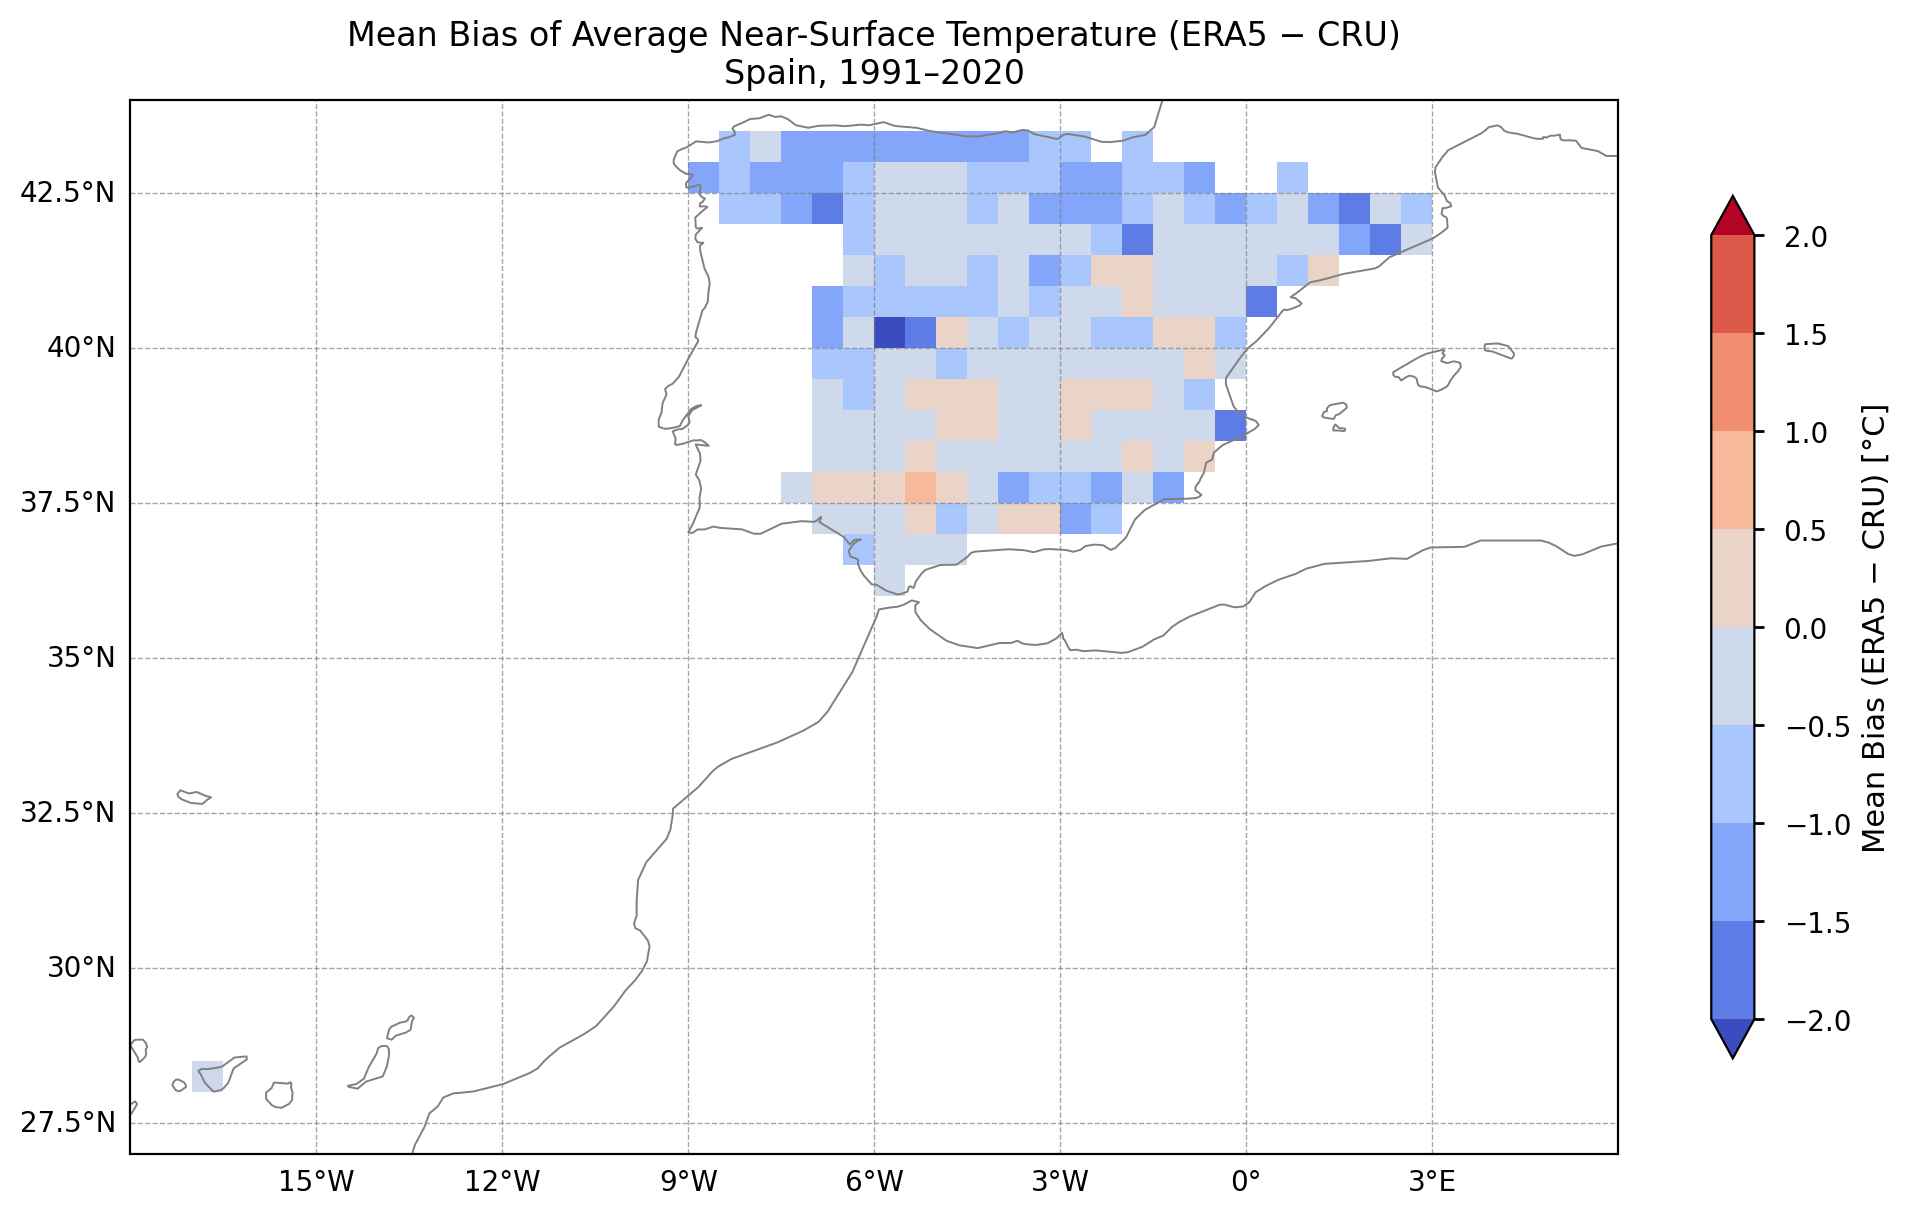

In [31]:
bias_map = mean_bias.squeeze()

# Define discrete levels
levels = [-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]

# Create discrete colormap
cmap = plt.get_cmap("coolwarm", len(levels) + 1)

# Normalization
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=cmap.N, extend="both")

# Plot
plt.figure(figsize=(12,8), dpi=200)
ax = plt.axes(projection=ccrs.PlateCarree())

im = bias_map.plot(
    ax=ax,
    cmap=cmap,
    norm=norm,
    add_colorbar=False
)

# Gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.7, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Coastlines
ax.add_feature(cfeature.COASTLINE, edgecolor='gray', linewidth=0.7)

# Colorbar
cbar = plt.colorbar(im, ax=ax, orientation="vertical", shrink=0.7, pad=0.05,
                    boundaries=levels, ticks=levels, extend="both")
cbar.set_label("Mean Bias (ERA5 − CRU) [°C]")

# Title
plt.title("Mean Bias of Average Near-Surface Temperature (ERA5 − CRU)\nSpain, 1991–2020", fontsize=12)
plt.show()

*Figure 4. Spatial distribution of the mean bias of the near surface temperature climatology for the period 1991–2020 over Spain, substracting ERA5-Land - CRU.*

![ES_CS_CLC_types.jpg](7e6dd410-9197-4f45-ba8c-d5e338cfb464.jpg)

Figure 5. Corine Land cover 2006 data for Spain. Source: European Environment Agency (2011) [[6]](https://www.eea.europa.eu/data-and-maps/figures/land-cover-2006-and-changes/spain) 

The 2 m temperature parameter in ERA5 is produced by coupling the atmospheric model of the ECMWF Integrated Forecast System (IFS) with the land-surface model (HTESSEL). The IFS assimilates observations, blending the model forecast with available data to produce the best estimate of the atmospheric state [[4]](https://confluence.ecmwf.int/display/CKB/ERA5%3A+data+documentation). In ERA5-Land, no assimilation is performed; instead, HTESSEL is run at higher resolution and forced by the meteorological fields from ERA5 to produce 2 m temperature and other land variables [[5]](https://confluence.ecmwf.int/display/CKB/ERA5-Land%3A+data+documentation).

On the other hand, CRU is based on observed anomalies, calculated relative to a 1961–1990 baseline. These anomalies are then interpolated using the angular-distance weighting (ADW) method to produce variables such a mean temperature on a regular 0.5° × 0.5° grid [[2]](https://doi.org/10.1038/s41597-020-0453-3). However, CRU also has limitations: its resolution is lower than that of ERA5-Land, and the interpolation process introduces uncertainties. Despite these drawbacks, we considered the comparison between the two products valuable, since CRU is more directly anchored to in-situ observations, whereas ERA5-Land derives 2 m temperature indirectly from model physics driven by assimilated atmospheric data.

Johannsen et al. (2019) [[7]](https://doi.org/10.3390/rs11212570) identified a systematic cold bias in ERA5 summertime daily maximum Land Surface Temperature (LST) over the Iberian Peninsula, which they attributed largely to the representation of vegetation cover in the HTESSEL land-surface model. Their analysis, based on comparisons with satellite-derived LST, showed that the bias was more pronounced in areas with dense vegetation, where model parameterizations of evapotranspiration and canopy processes tend to enhance surface cooling. It is important to note that LST, also known as skin temperature, differs from 2 m air temperature, and in this assessment we used ERA5-Land rather than ERA5. Nonetheless, examining the land cover map indicates that the bias in 2 m temperature also appears larger over forested areas than over arable land or permanent crops, particularly in northern Spain, suggesting that vegetation may be a contributing factor. However, other factors likely play a role as well: Johannsen et al. focused on summer because the LST bias was largest in that season, whereas in our analysis the cold bias is more pronounced in colder seasons, potentially linked to other processes and parameters.

Similar findings, regarding the cold bias, have been reported in the literature. For example, Yilmaz (2023) [[8]](https://doi.org/10.1016/j.scitotenv.2022.159182) analyzed temperature trends in Turkey and found a high degree of consistency between the trends in ERA5/ERA5-Land and in-situ observations, suggesting that ERA5-Land may serve as a substitute for direct observations. Like our findings, Yilmaz observed a cold bias in ERA5-Land data compared to observations. Zhao and He (2022) [[9]](https://doi.org/10.3389/feart.2022.907730) found similar results in their study of the Qilian Mountains in China, where surface 2 m air temperature data from 17 meteorological stations (1979–2017) were compared to the ERA5-Land product. They reported a significant warming trend of 0.488°C/decade in the observed data, and ERA5-Land reanalysis captured the trend well at 0.379°C/decade. Again, a bias between ERA5-Land temperature and observations was noted. They concluded that ERA5-Land reliably reproduces temperature trends and is suitable for scientific research in the region.

Based on our results and supporting literature, ERA5-Land is a reliable dataset for assessing climate change trends, as the estimated trends closely match those from CRU (1950–2024). However, absolute temperature values are subject to a known cold bias, which should be considered when interpreting results.

## ℹ️ If you want to know more

* J. Muñoz-Sabater, Dutra, E., Agustí-Panareda, A., Albergel, C., Arduini, G., Balsamo, G., Boussetta, S., Choulga, M., Harrigan, S., Hersbach, H., Martens, B., Miralles, D. G., Piles, M., Rodríguez-Fernández, N. J., Zsoter, E., Buontempo, C., & Thépaut, J.-N. (2021) ERA5-Land: A state-of-the-art global reanalysis dataset for land applications, Earth Syst. Sci. Data,13, 4349–4383. [](https://doi.org/10.5194/essd-13-4349-2021).
* Copernicus (2025) Copernicus: Third-warmest July marks slight respite from record global temperatures [](https://climate.copernicus.eu/copernicus-third-warmest-july-marks-slight-respite-record-global-temperatures)

### Key resources

Code libraries used:
* [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control`,  prepared by [B-Open](https://www.bopen.eu/)

### References

[[1]](https://doi.org/10.3390/land14010085) Arellano, B., Zheng, Q. & Roca, J. (2025). Analysis of climate change effects on precipitation and temperature trends in Spain. Land, 14(1), 85.

[[2]](https://doi.org/10.1038/s41597-020-0453-3) Harris, I., Osborn, T.J., Jones, P. & Lister, D. (2020) Version 4 of the CRU TS monthly high-resolution gridded multivariate climate dataset. Sci Data 7, 109.

[[3]](https://climateknowledgeportal.worldbank.org/country/spain/climate-data-historical) Climate Knowledge Portal (2020) Observed Climatology of Average Mean Surface Air Temperature (accessed on 01/10/2025).

[[4]](https://confluence.ecmwf.int/display/CKB/ERA5%3A+data+documentation) ECMWF (2025) ERA5: data documentation.

[[5]](https://confluence.ecmwf.int/display/CKB/ERA5-Land%3A+data+documentation) ECMWF (2025) ERA5-Land: data documentation.

[[6]](https://www.eea.europa.eu/data-and-maps/figures/land-cover-2006-and-changes/spain) European Environment Agency (2011) Land cover 2006 and changes country analysis, Spain.

[[7]](https://doi.org/10.3390/rs11212570) Johannsen, F., Ermida, S., Martins, J. P. A., Trigo, I. F., Nogueira, M. & Dutra, E. (2019). Cold bias of ERA5 summertime daily maximum land surface temperature over the Iberian Peninsula. Remote Sensing, 11(21), 2570.

[[8]](https://doi.org/10.1016/j.scitotenv.2022.159182) Yilmaz, M. (2023). Accuracy assessment of temperature trends from ERA5 and ERA5-Land. Science of the Total Environment, 856(Pt 2), 159182.

[[9]](https://doi.org/10.3389/feart.2022.907730) Zhao, Peng & He, Zhibin. (2022). A First Evaluation of ERA5-Land Reanalysis Temperature Product Over the Chinese Qilian Mountains. Frontiers in Earth Science. 10. 907730. 10.3389/feart.2022.907730. 